In [34]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.patches import Rectangle
from cycler import cycler
from matplotlib.transforms import blended_transform_factory as blend

from train.data import get_dataset

#root = './experiments/new/'
root = './here/5/'
figures = os.path.join(root, 'figures')
os.makedirs(figures, exist_ok=True)

paths = [
    ('non_parametric_alpha_00_', 'Baseline'),
    ('parametric_alpha_00_norm', r'Forced normaliz.'),
    ('parametric_alpha_0005', r'$\lambda=0.005$'),
    ('parametric_alpha_005', r'$\lambda=0.05$'),
    ('parametric_alpha_05', r'$\lambda=0.5$'),
    ('parametric_alpha_15', r'$\lambda=1.5$'),
    ('parametric_alpha_3', r'$\lambda=3$'),
    ('parametric_alpha_5', r'$\lambda=5$'),
    ('parametric_alpha_10', r'$\lambda=10$'),
]
data = get_dataset(seed=33)
get_path = lambda y: [x for x in os.listdir(root) if x.startswith(y)][0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


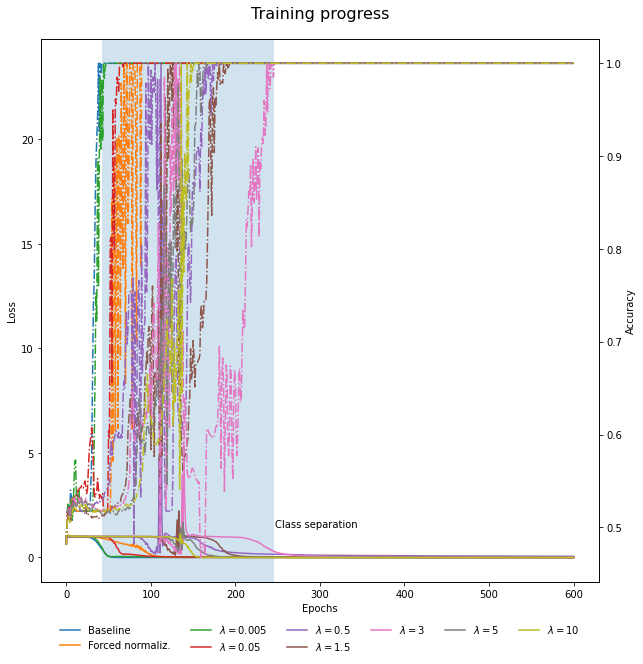

In [35]:
from train.model import load

fig, ax = plt.subplots(figsize=(10,10))
sax = ax.twinx()

sep = list((1e10, 0))
separability = {'non_param': 1e10, 'param': 1e10}

for path_, leg in paths:
    
    key = 'param' if path_.startswith('param') else 'non_param'
    path = os.path.join(root, get_path(path_))
    
    results = load(path, 'train')
    ax.plot(results['loss'], label=leg)
    sax.plot(results['accuracy'], linestyle='-.')
    
    sep_point = len(results['accuracy']) - [x != 1.0 for x in results['accuracy'][::-1]].index(True)
    if sep_point < separability[key]:
        separability[key] = sep_point
        
    if sep_point < sep[0]:
        sep[0] = sep_point
    if sep_point > sep[1]:
        sep[1] = sep_point
        

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
sax.set_ylabel('Accuracy')
ax.legend(
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper center', ncol=6
)
plt.title('Training progress', fontsize=16, pad=20)

def plot_separability(ax, y=0.05):
    trans = blend(ax.transData, ax.transAxes)
    if separability['param'] != separability['non_param']:
        ax.axvline(separability['param'], color='black', linewidth=0.5)
        ax.text(separability['param'] + 1, y,'[Param] Class separation', transform=trans)

        ax.axvline(separability['non_param'], color='black', linewidth=0.5)
        ax.text(separability['non_param'] + 1, y,'[Baseline] Class separation', transform=trans)
    else:
        ax.axvline(separability['non_param'], color='black', linewidth=0.5)
        ax.text(separability['non_param'] + 1, y,'Class separation', transform=trans)
        
def plot_separability(ax, y=0.05):
    trans = blend(ax.transData, ax.transAxes)
    ax.text(sep[1] + 1, y, 'Class separation', transform=trans)
    ax.add_patch(Rectangle((sep[0], 0), (sep[1] -sep[0]), 1, transform=trans, alpha=0.2))

plot_separability(ax, 0.1)
plt.savefig(os.path.join(figures,  'progress.svg'), bbox_inches='tight')

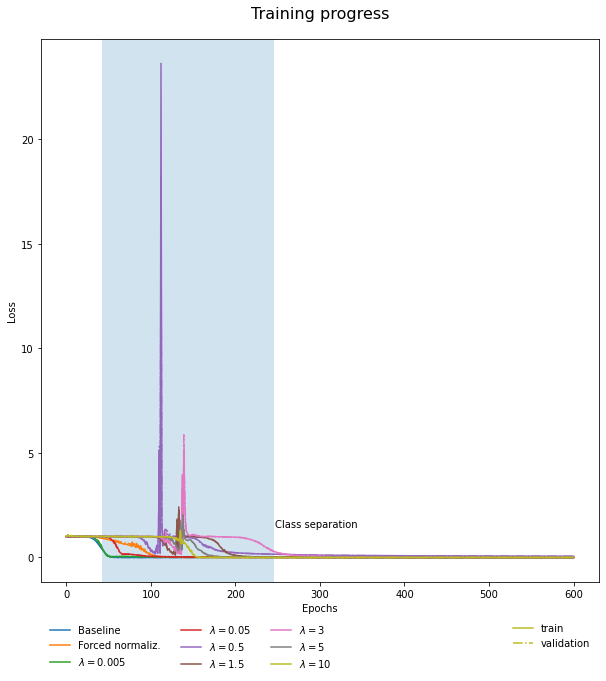

In [36]:
from train.model import load

fig, ax = plt.subplots(figsize=(10,10))
for path_, leg in paths:
    
    key = 'param' if path_.startswith('param') else 'non_param'
    path = os.path.join(root, get_path(path_))
    
    results = load(path, 'train')
    a = ax.plot(results['loss'], label=leg)
    
    results = load(path, 'test')
    b = ax.plot(results['loss'], color=a[-1].get_color(), linestyle='-.')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

leg = ax.legend(
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper left', ncol=3
)

ax.legend(
    handles=[a[-1],b[-1]],
    labels=['train', 'validation'],
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper right'
)
plt.title('Training progress', fontsize=16, pad=20)
ax.add_artist(leg)

plot_separability(ax, 0.1)
plt.savefig(os.path.join(figures,  'progress.svg'))

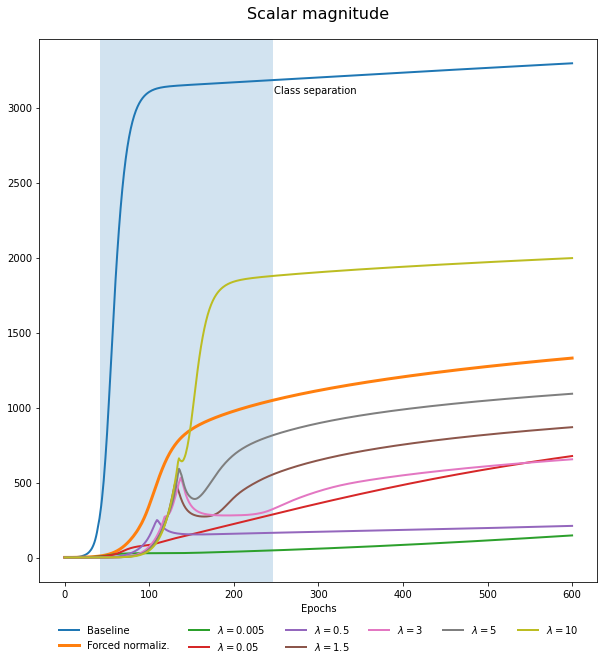

In [37]:
from train.analysis import collect_weights

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Scalar magnitude', fontsize=16, pad=20);

w = list()
for i, (path, leg) in enumerate(paths):
    
    param = path.startswith('param')
    w.append(collect_weights(path, param=param, root=root))
    line = ax.plot(w[i]['scalar'], linewidth= 3 if i == 1 else 2, label=leg)

w[0]['vector'] = w[0]['vector'] / np.linalg.norm(w[0]['vector'], axis=1)[:, np.newaxis]
        
ax.legend(
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper center', ncol=6
)
ax.set_xlabel('Epochs')
plot_separability(ax, y=0.9)

plt.savefig(os.path.join(figures,  'scalar.svg'), bbox_inches='tight')

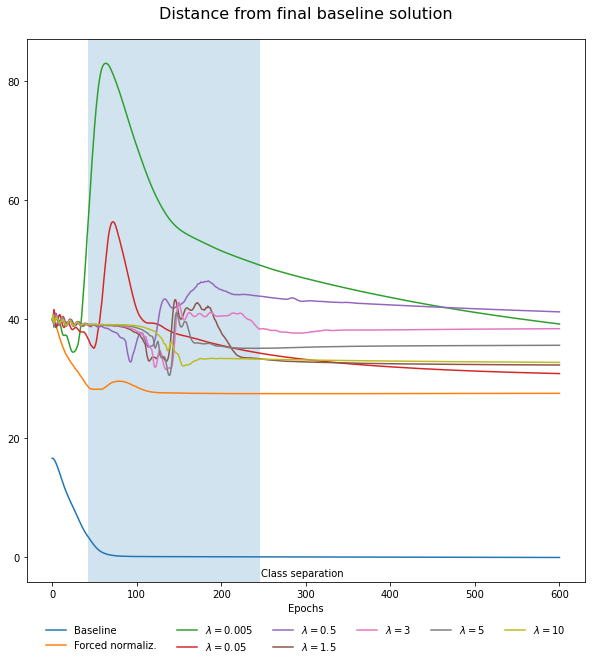

In [38]:
from train.analysis import collect_weights

fig, ax = plt.subplots(figsize=(10,10))


for i, (path, leg) in enumerate(paths):
    
    distance = np.sqrt((w[i]['vector'] - w[0]['vector'][-1])**2)
    w[i]['distance'] = np.sum(distance, axis=1)
    ax.plot(w[i]['distance'], label=leg)
    
ax.legend(
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper center', ncol=6
)
ax.set_xlabel('Epochs')

plt.title('Distance from final baseline solution', fontsize=16, pad=20);

plot_separability(ax, y=0.01)
plt.savefig(os.path.join(figures,  'distance.svg'), bbox_inches='tight')

In [39]:
# https://www.cs.upc.edu/~alquezar/articles/fnnsvm.pdf
# http://ww.web.stanford.edu/~hastie/Papers/margin.pdf
import json
from train.model import from_logs, load
redo = False
try: 
    with open(os.path.join(root, 'margins.json'), 'r') as f:
        margins = json.load(f)
        
except FileNotFoundError:
    margins = dict()
        
if not margins or redo:
    for path_ in paths:
        j = 0
        margin = list()
        point = list()
        path = os.path.join(root, get_path(path_))

        while True:
            try:
                model = from_logs(path, epoch=j)
            except IndexError:
                break
            j += 1
            margin.append((model(data.train.X)*data.train.y).min().item())
            point.append((model(data.train.X)*data.train.y).argmin().item())
            
        margins[path_[0]] = {'margin': margin, 'point': point}
    
    with open(os.path.join(root, 'margins.json'), 'w') as f:
        json.dump(margins, f)

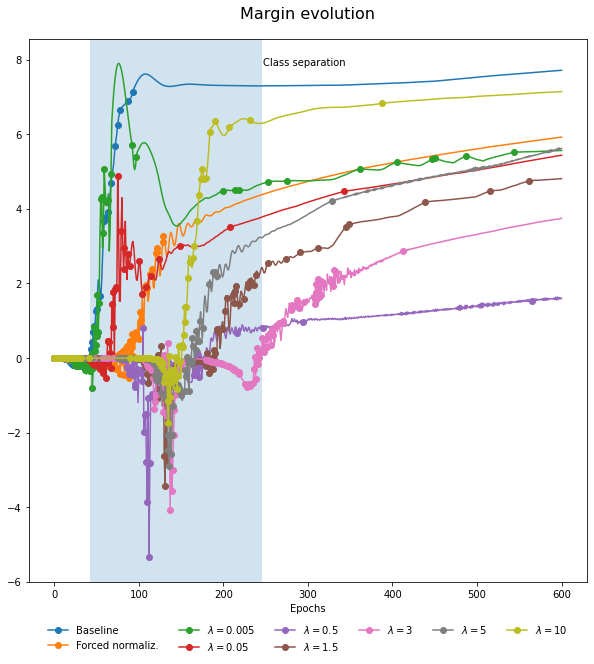

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('Epochs')

for path_, leg in paths:
    path = [x for x in os.listdir(root) if x.startswith(path_)][0]
    path = os.path.join(root, path)
    w = load(path, 'train')
    mark = margins[path_]['point']
    markers_on = [bool(x - y) for x, y in zip(mark[1:], mark[:-1])]
    markers_on = [i for i in range(len(markers_on)) if markers_on[i]]
    
    ax.plot(margins[path_]['margin'], label=leg, marker='o', markevery=markers_on)
    
ax.legend(
    frameon=False,
    bbox_to_anchor=(0., -0.16, 1., .1), loc='upper center', ncol=6
)
plt.title('Margin evolution', fontsize=16, pad=20)
plot_separability(ax, y=0.95)
plt.savefig(os.path.join(figures,  'margins.svg'), bbox_inches='tight')

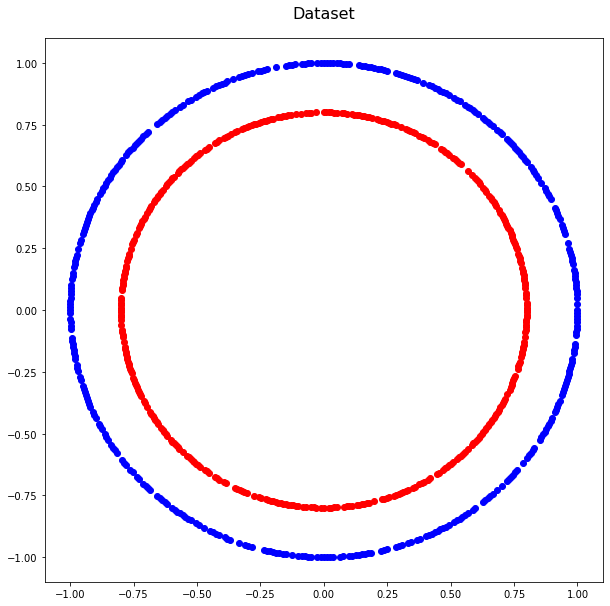

In [31]:
fig, ax = plt.subplots(figsize=(10,10))

X, y = data.train.X.numpy(), data.train.y.numpy()
x = X[y == 1]
ax.scatter(x[:, 0], x[:,1], color='red')

x = X[y != 1]
ax.scatter(x[:, 0], x[:,1], color='blue');
plt.title('Dataset', pad=20, fontsize=16)
plt.savefig(os.path.join(figures,  'dataset.svg'), bbox_inches='tight')

#### Verify homogeneity property

In [93]:
import torch
from copy import deepcopy
from exp.model import Model

a = Model(True, seed=13)
b = deepcopy(a)

g = 0
m = dict(b.named_parameters())
for t in range(len(b.scalars)):
    m[f'scalar{t}'] = torch.nn.Parameter(torch.tensor([10.]))
"""
g = 0
m = dict(b.named_parameters())
for k, v in m.items():
    if not k.startswith('scalar'):
        g += 1
        print(k, g)
        m[k] = v*10
"""
# take the tail out
b.load_state_dict(m)
print((a(data.train.X) - (0.1**(g))*b(data.train.X)))

tensor([ 1.6625, -2.4345,  2.9400,  2.7951,  8.1441,  4.1471,  1.4208,  3.7828,
        -4.8357, -2.1722,  2.5507,  6.5869,  6.1876, -2.8023, -3.8252,  7.7474,
         3.7601,  3.5432,  3.3044, -1.8680, -2.2413,  5.8242,  9.4028, -2.5452,
         4.2399,  7.5646,  3.5506, -1.6193, -3.1434, -3.7419,  4.0670,  3.6317,
         2.5870, -3.5806,  7.5498,  6.5283,  3.5982, -1.7777, -2.2328, -2.5666,
         1.2246, -3.7431,  6.5626,  4.9707, -2.2279,  3.9047, -1.6045,  9.4256,
         3.8259,  5.6201,  3.5860, -2.5999, -2.2612,  7.7001, -4.2825, -3.7710,
         0.1637,  3.1425,  7.8126,  7.0280, -1.9946, -2.7881, -4.9381, -3.6963,
         6.1916,  5.3410,  7.3687,  7.5222, -2.0681, -2.4644,  3.6917, -1.8957,
         4.4383,  1.0053, -2.1746,  1.8194, -3.3066,  5.0281,  7.1886,  0.2001,
        -2.2299,  6.3623,  8.3055,  3.2337,  6.9305,  1.3307, -0.6937, -2.2006,
         1.8890, -2.4496,  4.9533,  6.6502, -2.2298,  2.0007, -2.7668,  7.5579,
        -2.0523,  9.2409,  5.9848, -2.67